In [31]:
## Notebook env: mirtud_env (mirtud_env kernel)
### This notebook determines an e-distance for each perturbation relative to control cells to (relatively) quantify their magnitude ###

import h5py
import numpy as np
import pandas as pd
import nexusformat.nexus as nx
import tables
import scipy
import scanpy as sc
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as pl
%load_ext rpy2.ipython

# # Custom functions
# import sys
# sys.path.insert(1, '../src')
from scperturb import *

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [32]:
### things to vary to get better p-values and non-negative distances

## the control guide which things are assessed relative to (spend time picking good controls)
## assess # of control cells vs pertuabtion cells and vary the number of sampled cells in class imbalance
## look how big the radius of perturbation and control is in PC space and cutoff # of PCs used in dist calculation
## lower max variable features during to 500?


In [33]:
## Load in data ##
adata = sc.read('/home/ssobti/projects/mir_tud/110222_filtered_data/miR.concat.raw.adata_gex.guide_assigned.h5')

Only considering the two last: ['.guide_assigned', '.h5'].
Only considering the two last: ['.guide_assigned', '.h5'].


In [34]:
#meta data prior to filtering
meta = adata.obs
meta['guide'] = meta['guide'].astype('string')
meta.loc[meta.loc[:,'guide'].str.startswith('TuD_NC'), 'guide'] = 'TuD_NC'
meta['guide'] = meta['guide'].astype('category')
meta.dtypes

sample         category
barcode        category
guide          category
lor             float64
pvalue          float64
adj_pvalue      float64
max_umi         float64
n_umi           float64
m_umi           float64
v_umi           float64
log_max_umi     float64
log_n_umi       float64
log_m_umi       float64
dtype: object

In [35]:
count_df = meta.groupby(by = ['guide']).size().reset_index(name = 'cells')
idxs = count_df.loc[:,'guide'].str.startswith('TuD')
guide_type = ['control' if x is True else 'perturbation' for x in idxs]
count_df['type'] = guide_type
count_df

guide  cells          type
0             TuD_NC   3156       control
1    hsa-let-7a-2-3p     62  perturbation
2      hsa-let-7a-5p      9  perturbation
3      hsa-let-7b-3p     90  perturbation
4      hsa-let-7d-3p     50  perturbation
..               ...    ...           ...
373    hsa-miR-96-5p     74  perturbation
374    hsa-miR-98-3p     83  perturbation
375     hsa-miR-9903     80  perturbation
376   hsa-miR-99b-3p     71  perturbation
377   hsa-miR-99b-5p     76  perturbation

[378 rows x 3 columns]

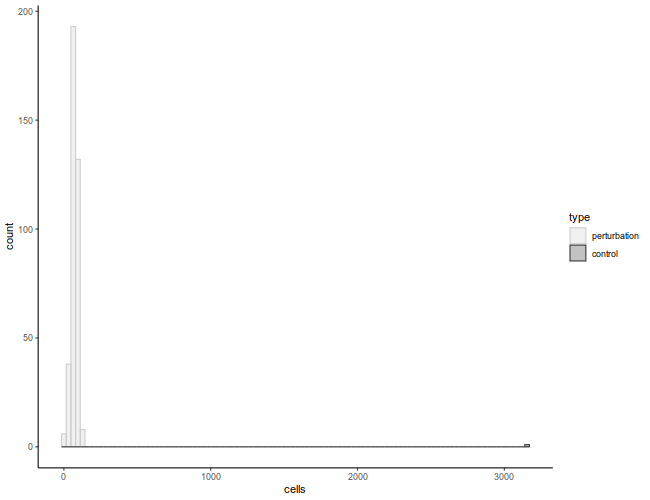

In [36]:
%%R -i count_df -w 650 -h 500
### data exploration of cells per perturbation with histogram

library(ggplot2)
count_df2 = count_df[!count_df$guide == 'TuD_NC_01',]
count_df2$type <- factor(count_df2$type, levels = c('perturbation', 'control'))

## without TuD_NC_01 which has 1687 cells
ggplot(count_df2, aes(x = cells, fill = type, color = type)) + 
geom_histogram(position = "identity", alpha = 0.3, bins = 100) + scale_color_grey(start = 0.8, end = 0.2) +
scale_fill_grey(start = 0.8, end = 0.2) + theme_classic()

In [37]:
adata.obs = meta
adata.obs.head()

sample           barcode            guide       lor  \
miR_1:AAACCCAAGGAGAGGC-1  miR_1  AAACCCAAGGAGAGGC  hsa-miR-203a-3p  5.453121   
miR_1:AAACCCAAGGTAAACT-1  miR_1  AAACCCAAGGTAAACT    hsa-miR-93-3p  6.012001   
miR_1:AAACCCACAACGATCT-1  miR_1  AAACCCACAACGATCT  hsa-miR-130b-3p  5.864701   
miR_1:AAACCCACACGATTCA-1  miR_1  AAACCCACACGATTCA           TuD_NC  5.859895   
miR_1:AAACCCACAGTCAACT-1  miR_1  AAACCCACAGTCAACT  hsa-miR-147b-5p  5.632808   

                                 pvalue     adj_pvalue  max_umi  n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  2.983000e-159  3.010603e-152     67.0   78.0   
miR_1:AAACCCAAGGTAAACT-1  3.907611e-225  3.943769e-218     97.0  108.0   
miR_1:AAACCCACAACGATCT-1  3.299362e-202  3.329893e-195     89.0  113.0   
miR_1:AAACCCACACGATTCA-1  2.574602e-201  2.598426e-194     96.0  114.0   
miR_1:AAACCCACAGTCAACT-1  3.564463e-178  3.597446e-171     71.0   86.0   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_1:AAACCCAAGGAGAGGC-1  0.196474  11.324937     1.826075   1.892095   
miR_1:AAACCCAAGGTAAACT-1  0.272040  23.713686     1.986772   2.033424   
miR_1:AAACCCACAACGATCT-1  0.284635  19.981910     1.949390   2.053078   
miR_1:AAACCCACACGATTCA-1  0.287154  23.235516     1.982271   2.056905   
miR_1:AAACCCACAGTCAACT-1  0.216625  12.725683     1.851258   1.934498   

                          log_m_umi  
miR_1:AAACCCAAGGAGAGGC-1  -0.706696  
miR_1:AAACCCAAGGTAAACT-1  -0.565367  
miR_1:AAACCCACAACGATCT-1  -0.545712  
miR_1:AAACCCACACGATTCA-1  -0.541886  
miR_1:AAACCCACAGTCAACT-1  -0.664292

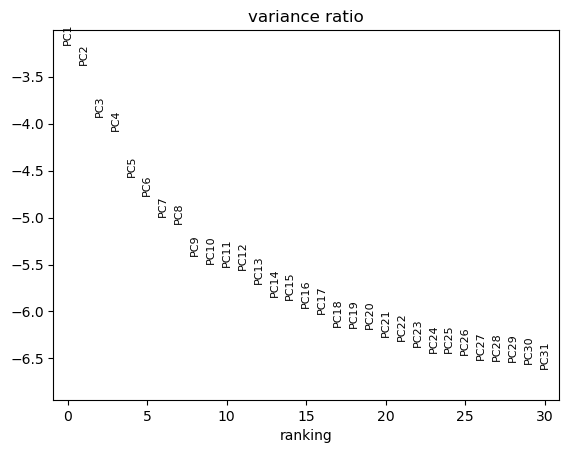

In [38]:
# basic qc and pp
adata.layers['counts'] = adata.X.copy()
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_genes(adata, min_cells=50)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)


# high class imbalance
adata = equal_subsampling(adata, 'guide', N_min=50)
sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

# select HVGs
n_var_max = 2000  # max total features to select
sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


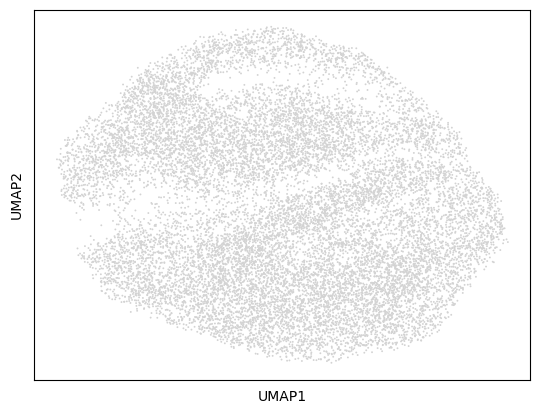

In [39]:
### figure out how many PCs needed
sc.pp.pca(adata, n_comps=10, use_highly_variable=True)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata)

In [40]:
adata.uns['processed'] = True

In [41]:
#meta data post-filtering
meta = adata.obs
meta

sample           barcode           guide       lor  \
miR_2:ATGACCAAGGACCCAA-1  miR_2  ATGACCAAGGACCCAA          TuD_NC  6.085001   
miR_2:TCACGCTCAAGTCCCG-1  miR_2  TCACGCTCAAGTCCCG          TuD_NC  1.940161   
miR_1:CGTGCTTGTGATAGTA-1  miR_1  CGTGCTTGTGATAGTA          TuD_NC  3.263895   
miR_3:GTGAGTTAGGCCTAGA-1  miR_3  GTGAGTTAGGCCTAGA          TuD_NC  0.625439   
miR_3:CCTTCAGCAAGTTCCA-1  miR_3  CCTTCAGCAAGTTCCA          TuD_NC  0.771760   
...                         ...               ...             ...       ...   
miR_1:TTAATCCCAATAGTGA-1  miR_1  TTAATCCCAATAGTGA  hsa-miR-423-5p  5.174266   
miR_3:GCATCGGCAAGTGGGT-1  miR_3  GCATCGGCAAGTGGGT  hsa-miR-423-5p  6.782205   
miR_2:TACCCACGTAGGCTGA-1  miR_2  TACCCACGTAGGCTGA  hsa-miR-423-5p  3.057838   
miR_3:TCACTATGTGACATCT-1  miR_3  TCACTATGTGACATCT  hsa-miR-423-5p  5.054166   
miR_2:TTTCAGTCAGGACATG-1  miR_2  TTTCAGTCAGGACATG  hsa-miR-423-5p  4.931333   

                                 pvalue     adj_pvalue  max_umi  n_umi  \
miR_2:ATGACCAAGGACCCAA-1  4.940492e-197  5.141941e-190     84.0  114.0   
miR_2:TCACGCTCAAGTCCCG-1   4.462870e-41   4.644844e-34     21.0   39.0   
miR_1:CGTGCTTGTGATAGTA-1   5.927000e-38   5.981845e-31     31.0   46.0   
miR_3:GTGAGTTAGGCCTAGA-1   4.989342e-07   1.000000e+00      3.0   18.0   
miR_3:CCTTCAGCAAGTTCCA-1   8.954815e-79   7.170559e-72     49.0  149.0   
...                                 ...            ...      ...    ...   
miR_1:TTAATCCCAATAGTGA-1  5.451615e-135  5.502061e-128     53.0   62.0   
miR_3:GCATCGGCAAGTGGGT-1  4.940656e-324  3.956226e-317    165.0  253.0   
miR_2:TACCCACGTAGGCTGA-1   3.136717e-47   3.264617e-40     19.0   36.0   
miR_3:TCACTATGTGACATCT-1  1.129858e-165  9.047329e-159     67.0   99.0   
miR_2:TTTCAGTCAGGACATG-1  7.062655e-102   7.350636e-95     37.0   43.0   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_2:ATGACCAAGGACCCAA-1  0.287154  17.826425     1.924279   2.056905   
miR_2:TCACGCTCAAGTCCCG-1  0.098237   1.230224     1.322219   1.591065   
miR_1:CGTGCTTGTGATAGTA-1  0.115869   2.456237     1.491362   1.662758   
miR_3:GTGAGTTAGGCCTAGA-1  0.045340   0.058545     0.477121   1.255273   
miR_3:CCTTCAGCAAGTTCCA-1  0.375315   9.240096     1.690196   2.173186   
...                            ...        ...          ...        ...   
miR_1:TTAATCCCAATAGTGA-1  0.156171   7.091711     1.724276   1.792392   
miR_3:GCATCGGCAAGTGGGT-1  0.637280  68.615576     2.217484   2.403121   
miR_2:TACCCACGTAGGCTGA-1  0.090680   0.966504     1.278754   1.556303   
miR_3:TCACTATGTGACATCT-1  0.249370  11.399779     1.826075   1.995635   
miR_2:TTTCAGTCAGGACATG-1  0.108312   3.460461     1.568202   1.633468   

                          log_m_umi  n_counts  n_genes_by_counts  \
miR_2:ATGACCAAGGACCCAA-1  -0.541886   31427.0               6321   
miR_2:TCACGCTCAAGTCCCG-1  -1.007726   32514.0               6641   
miR_1:CGTGCTTGTGATAGTA-1  -0.936033   48664.0               7512   
miR_3:GTGAGTTAGGCCTAGA-1  -1.343518   54573.0               8128   
miR_3:CCTTCAGCAAGTTCCA-1  -0.425604   48031.0               7710   
...                             ...       ...                ...   
miR_1:TTAATCCCAATAGTGA-1  -0.806399   17784.0               5098   
miR_3:GCATCGGCAAGTGGGT-1  -0.195670   61084.0               8456   
miR_2:TACCCACGTAGGCTGA-1  -1.042488   50945.0               7854   
miR_3:TCACTATGTGACATCT-1  -0.603155   47890.0               7796   
miR_2:TTTCAGTCAGGACATG-1  -0.965322   24743.0               5900   

                          total_counts  total_counts_mt  pct_counts_mt  
miR_2:ATGACCAAGGACCCAA-1       31427.0           1402.0       4.461132  
miR_2:TCACGCTCAAGTCCCG-1       32514.0           1826.0       5.616043  
miR_1:CGTGCTTGTGATAGTA-1       48664.0           3546.0       7.286701  
miR_3:GTGAGTTAGGCCTAGA-1       54573.0           4443.0       8.141389  
miR_3:CCTTCAGCAAGTTCCA-1       48031.0           2822.0       5.875372  
...                                ...              ...

# E-distance

In [42]:
# pre-compute pairwise pca distances
pwd = pairwise_pca_distances(adata, 'guide', obsm_key='X_pca', dist='sqeuclidean', verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 328/328 [03:00<00:00,  1.82it/s]


In [43]:
# Compute E-distances
estats = edist(adata, obs_key='guide', obsm_key='X_pca', pwd=pwd, dist='sqeuclidean')

In [44]:
# square matrix, all pairs of perturbations get an e-distance
estats.to_csv('/home/ssobti/projects/mir_tud/output_data/edist/miR_estats_mtx_combined_controls.csv')
estats.head()

TuD_NC  hsa-miR-3605-5p  hsa-miR-122-5p  hsa-miR-1255a  \
TuD_NC             0.000000         9.268803       21.057271       0.952242   
hsa-miR-3605-5p    9.268803         0.000000       -6.885274      -6.609049   
hsa-miR-122-5p    21.057271        -6.885274        0.000000      12.706523   
hsa-miR-1255a      0.952242        -6.609049       12.706523       0.000000   
hsa-miR-10527-5p -10.476924        -8.756851        7.413626     -13.916598   

                  hsa-miR-10527-5p  hsa-miR-3662  hsa-miR-4677-3p  \
TuD_NC                  -10.476924    -13.811743        -1.085586   
hsa-miR-3605-5p          -8.756851     -1.857528        -0.992707   
hsa-miR-122-5p            7.413626      4.714733        -2.621693   
hsa-miR-1255a           -13.916598     -4.363165         3.522719   
hsa-miR-10527-5p          0.000000    -14.163186        -4.891318   

                  hsa-miR-3928-3p  hsa-miR-489-3p  hsa-miR-378c  ...  \
TuD_NC                  22.176855        0.917484     -3.991043  ...   
hsa-miR-3605-5p        -12.079026       -3.846519     -9.563930  ...   
hsa-miR-122-5p          -5.283624        3.396001      6.384922  ...   
hsa-miR-1255a            1.747145       -1.426691    -10.046904  ...   
hsa-miR-10527-5p         2.868858       -7.298649    -15.726137  ...   

                  hsa-miR-30c-5p  hsa-miR-191-5p  hsa-miR-33a-5p  \
TuD_NC                  1.555399        1.598573       -8.654910   
hsa-miR-3605-5p       -12.630114        2.124953        6.922760   
hsa-miR-122-5p         -7.108010       -0.240224        5.379919   
hsa-miR-1255a          -2.650669       -7.475167        5.194373   
hsa-miR-10527-5p       -5.340170       -9.033537       -8.935741   

                  hsa-miR-196a-5p  hsa-miR-320a-3p  hsa-miR-4742-3p  \
TuD_NC                 -11.832736         7.693747       -10.950555   
hsa-miR-3605-5p         10.300279       -17.341133        -2.263226   
hsa-miR-122-5p          12.011858        -2.543684         9.841499   
hsa-miR-1255a            6.930227       -11.564596       -10.833981   
hsa-miR-10527-5p        -7.380771       -10.238087       -16.171737   

                  hsa-let-7d-3p  hsa-miR-191-3p  hsa-miR-301a-5p  \
TuD_NC                 0.004395       -5.584170        29.749374   
hsa-miR-3605-5p       -3.725412       24.158082       -12.239684   
hsa-miR-122-5p         7.353394       41.483778        -0.840569   
hsa-miR-1255a         -7.433139        2.795595        14.663335   
hsa-miR-10527-5p      -3.352007       -6.462295        10.436553   

                  hsa-miR-423-5p  
TuD_NC                  3.301903  
hsa-miR-3605-5p        -3.402473  
hsa-miR-122-5p         -3.559460  
hsa-miR-1255a           6.193333  
hsa-miR-10527-5p       -3.685647  

[5 rows x 328 columns]

E-distance relative to control KD (plotted better in R below)

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/categorical.py:3543: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


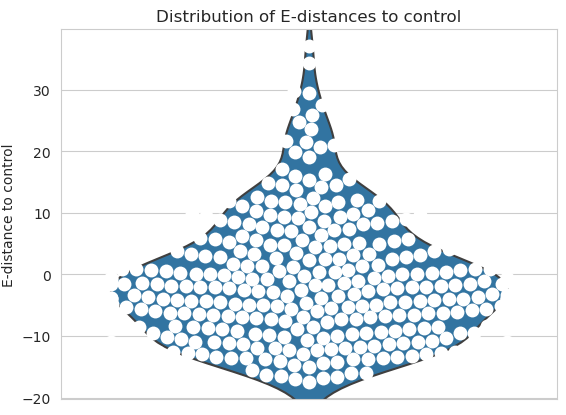

In [45]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['TuD_NC'], inner=None)
    sns.swarmplot(data=estats.loc['TuD_NC'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

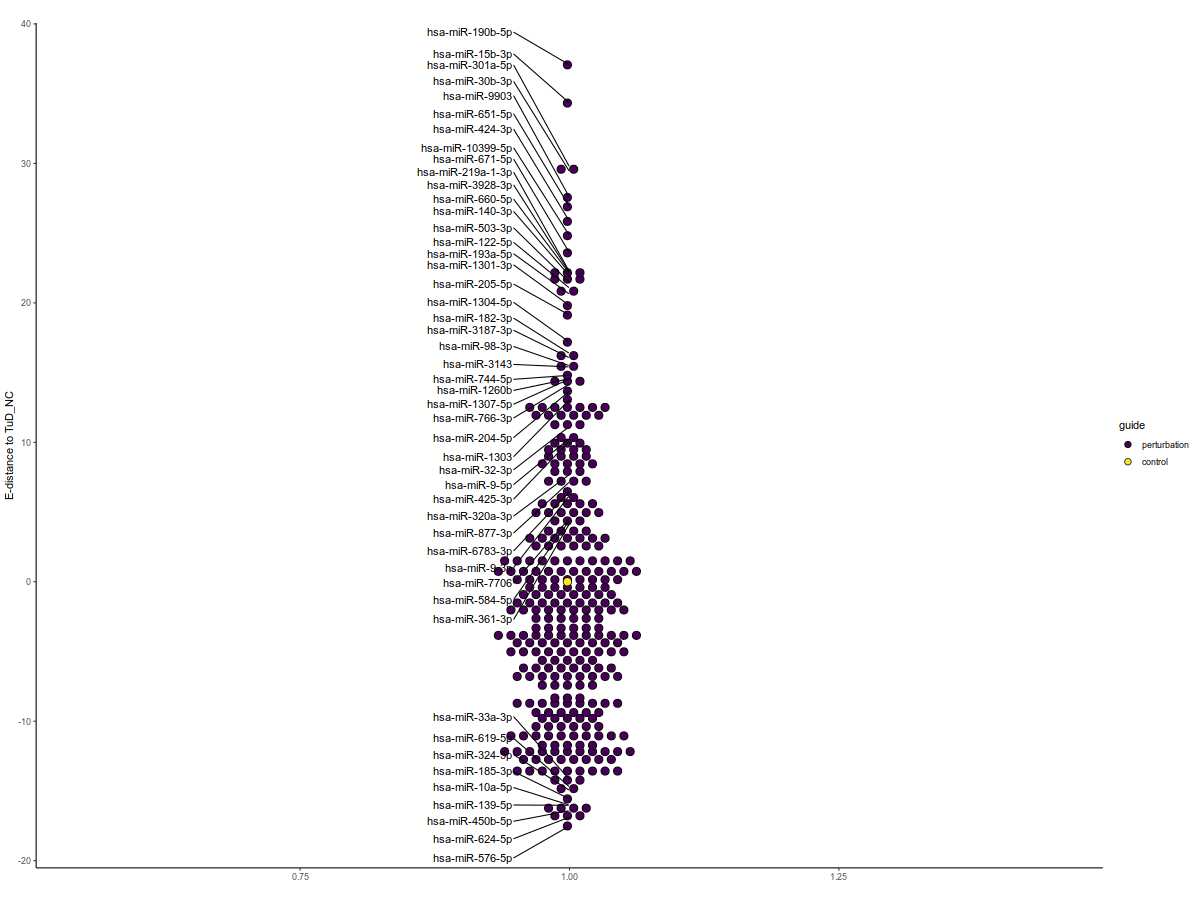

In [46]:
%%R -i estats -w 1200 -h 900
library(stringr)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(dplyr)

## draw barplots showing distances of the perturbations to each of the controls
## capture top 20% furthest guides from each of the controls


startsWith(colnames(estats), prefix = 'TuD') -> status
control_status = 1:length(status)
control_status[status] <- 'control'
control_status[!status] <- 'perturbation'
estats_control1 <- data.frame(comparison_to_control_NC1 = estats[,'TuD_NC'], guide = control_status, guide_nm = rownames(estats))
estats_control1 <- estats_control1[order(estats_control1$guide, decreasing = TRUE),]
estats_control1$guide <- factor(estats_control1$guide, levels = c('perturbation', 'control'))
tp20_pct <- as.character(estats_control1[order(estats_control1$comparison_to_control_NC1, decreasing = TRUE),"guide_nm"][1:ceiling(0.2*nrow(estats_control1))])
dotplot = ggplot(estats_control1, aes(x = 1, y=comparison_to_control_NC1, fill = guide)) + 
    geom_dotplot(binaxis='y', stackdir='center',
                 stackratio=1.5, dotsize=1.2, binwidth = 0.5) + scale_fill_viridis_d() + 
    geom_text_repel(aes(y = comparison_to_control_NC1, x = 1, label = guide_nm),
                    xlim = c(0, 0.95), 
                    direction = "y") +
    theme_classic() + ylab('E-distance to TuD_NC') + xlab('') + ggtitle('')

dotplot

Heatmap of pariwise E-distances of perturbations to each other

In [47]:
## in this heatmap a lighter color means a perturbation is further away from another perturbation
order = estats.sort_index().index
clus_fig = sns.clustermap(estats.loc[order, order], figsize=[100,100])
pl.show()
clus_fig.savefig('/home/ssobti/projects/mir_tud/output_data/edist/miR_edist_heatmap_combined_controls.pdf')

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


In [48]:
## better color scheme
order = estats.sort_index().index
clus_fig = sns.clustermap(estats.loc[order, order], figsize=[100,100], cmap="vlag", vmin = -10, vmax = 10, cbar_kws={"ticks":[-10, -5,  0, 5,  10]})
pl.show()
clus_fig.savefig('/home/ssobti/projects/mir_tud/output_data/edist/miR_edist_heatmap_color2_combined_controls.pdf')

/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


# E-testing (p-value calculation)

In [49]:
# e-testing (slow) -- here's what it's doing based on the paper:
## pvalue is found by combining the control cells and pertubation cells and switching their control/perturbation labels
## randomly 100 times to see how many times one gets a distance larger than when using the true original labels
## p-values are then adjusted using the Holm-Sidak method for multiple comparisons
df = etest(adata, obs_key='guide', obsm_key='X_pca', dist='sqeuclidean', control='TuD_NC', alpha=0.05, runs=100)

100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [16:03<00:00,  9.63s/it]
/home/ssobti/miniconda3/envs/mirtud_env/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [50]:
## convert all distances to z-scores,
## then find new pvalue_adj by summing the z


In [51]:
df.to_csv('/home/ssobti/projects/mir_tud/output_data/edist/miR_etest_df_combined_controls.csv')
df.sort_values('pvalue_adj')

edist  pvalue  significant  pvalue_adj  significant_adj
TuD_NC            0.000000    0.00         True    0.000000             True
hsa-miR-190b-5p  37.067135    0.01         True    0.962614            False
hsa-miR-424-3p   25.837278    0.02         True    0.998621            False
hsa-miR-30b-3p   29.415318    0.03         True    0.999950            False
hsa-miR-301a-5p  29.749374    0.03         True    0.999950            False
...                    ...     ...          ...         ...              ...
hsa-miR-2110     11.036847    0.20        False    1.000000            False
hsa-miR-210-3p   -4.541526    0.56        False    1.000000            False
hsa-miR-21-3p    -3.878803    0.60        False    1.000000            False
hsa-miR-22-5p    -3.394732    0.49        False    1.000000            False
hsa-miR-99b-5p    5.562226    0.24        False    1.000000            False

[328 rows x 5 columns]

In [60]:
df.sort_values('pvalue')

edist  pvalue significant  pvalue_adj significant_adj
TuD_NC             0.000000    0.00     control    0.000000         control
hsa-miR-190b-5p   37.067135    0.01        True    0.962614           False
hsa-miR-424-3p    25.837278    0.02        True    0.998621           False
hsa-miR-301a-5p   29.749374    0.03        True    0.999950           False
hsa-miR-30b-3p    29.415318    0.03        True    0.999950           False
...                     ...     ...         ...         ...             ...
hsa-miR-491-3p   -16.951664    0.98       False    1.000000           False
hsa-miR-139-5p   -16.028300    0.99       False    1.000000           False
hsa-miR-576-5p   -17.511865    0.99       False    1.000000           False
hsa-miR-450b-5p  -16.413651    1.00       False    1.000000           False
hsa-miR-128-1-5p -16.451193    1.00       False    1.000000           False

[328 rows x 5 columns]

In [96]:
df.sort_values('pvalue').index[-1]

'hsa-miR-128-1-5p'

### Scatter plot of E-distance from control vs p-value

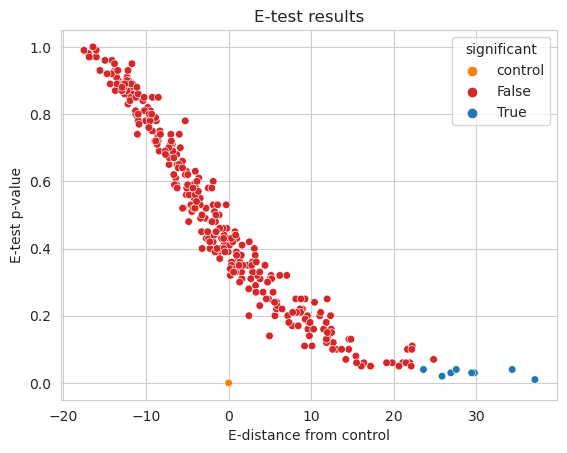

In [52]:
df.loc[df.index=='TuD_NC', 'significant'] = 'control'
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue', x='edist', hue='significant', palette={True: 'tab:blue', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test p-value')
pl.show()

### Scatter plot of E-distance from control vs adjusted p-value

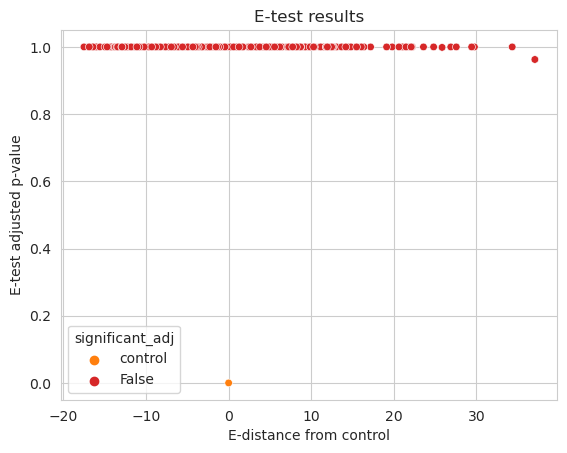

In [53]:
df.loc[df.index=='TuD_NC', 'significant_adj'] = 'control'
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:blue', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test adjusted p-value')
pl.show()

In [54]:
meta2 = sc.get.obs_df(adata, keys = adata.obs.columns.tolist())
meta2

sample           barcode           guide       lor  \
miR_2:ATGACCAAGGACCCAA-1  miR_2  ATGACCAAGGACCCAA          TuD_NC  6.085001   
miR_2:TCACGCTCAAGTCCCG-1  miR_2  TCACGCTCAAGTCCCG          TuD_NC  1.940161   
miR_1:CGTGCTTGTGATAGTA-1  miR_1  CGTGCTTGTGATAGTA          TuD_NC  3.263895   
miR_3:GTGAGTTAGGCCTAGA-1  miR_3  GTGAGTTAGGCCTAGA          TuD_NC  0.625439   
miR_3:CCTTCAGCAAGTTCCA-1  miR_3  CCTTCAGCAAGTTCCA          TuD_NC  0.771760   
...                         ...               ...             ...       ...   
miR_1:TTAATCCCAATAGTGA-1  miR_1  TTAATCCCAATAGTGA  hsa-miR-423-5p  5.174266   
miR_3:GCATCGGCAAGTGGGT-1  miR_3  GCATCGGCAAGTGGGT  hsa-miR-423-5p  6.782205   
miR_2:TACCCACGTAGGCTGA-1  miR_2  TACCCACGTAGGCTGA  hsa-miR-423-5p  3.057838   
miR_3:TCACTATGTGACATCT-1  miR_3  TCACTATGTGACATCT  hsa-miR-423-5p  5.054166   
miR_2:TTTCAGTCAGGACATG-1  miR_2  TTTCAGTCAGGACATG  hsa-miR-423-5p  4.931333   

                                 pvalue     adj_pvalue  max_umi  n_umi  \
miR_2:ATGACCAAGGACCCAA-1  4.940492e-197  5.141941e-190     84.0  114.0   
miR_2:TCACGCTCAAGTCCCG-1   4.462870e-41   4.644844e-34     21.0   39.0   
miR_1:CGTGCTTGTGATAGTA-1   5.927000e-38   5.981845e-31     31.0   46.0   
miR_3:GTGAGTTAGGCCTAGA-1   4.989342e-07   1.000000e+00      3.0   18.0   
miR_3:CCTTCAGCAAGTTCCA-1   8.954815e-79   7.170559e-72     49.0  149.0   
...                                 ...            ...      ...    ...   
miR_1:TTAATCCCAATAGTGA-1  5.451615e-135  5.502061e-128     53.0   62.0   
miR_3:GCATCGGCAAGTGGGT-1  4.940656e-324  3.956226e-317    165.0  253.0   
miR_2:TACCCACGTAGGCTGA-1   3.136717e-47   3.264617e-40     19.0   36.0   
miR_3:TCACTATGTGACATCT-1  1.129858e-165  9.047329e-159     67.0   99.0   
miR_2:TTTCAGTCAGGACATG-1  7.062655e-102   7.350636e-95     37.0   43.0   

                             m_umi      v_umi  log_max_umi  log_n_umi  \
miR_2:ATGACCAAGGACCCAA-1  0.287154  17.826425     1.924279   2.056905   
miR_2:TCACGCTCAAGTCCCG-1  0.098237   1.230224     1.322219   1.591065   
miR_1:CGTGCTTGTGATAGTA-1  0.115869   2.456237     1.491362   1.662758   
miR_3:GTGAGTTAGGCCTAGA-1  0.045340   0.058545     0.477121   1.255273   
miR_3:CCTTCAGCAAGTTCCA-1  0.375315   9.240096     1.690196   2.173186   
...                            ...        ...          ...        ...   
miR_1:TTAATCCCAATAGTGA-1  0.156171   7.091711     1.724276   1.792392   
miR_3:GCATCGGCAAGTGGGT-1  0.637280  68.615576     2.217484   2.403121   
miR_2:TACCCACGTAGGCTGA-1  0.090680   0.966504     1.278754   1.556303   
miR_3:TCACTATGTGACATCT-1  0.249370  11.399779     1.826075   1.995635   
miR_2:TTTCAGTCAGGACATG-1  0.108312   3.460461     1.568202   1.633468   

                          log_m_umi  n_counts  n_genes_by_counts  \
miR_2:ATGACCAAGGACCCAA-1  -0.541886   31427.0               6321   
miR_2:TCACGCTCAAGTCCCG-1  -1.007726   32514.0               6641   
miR_1:CGTGCTTGTGATAGTA-1  -0.936033   48664.0               7512   
miR_3:GTGAGTTAGGCCTAGA-1  -1.343518   54573.0               8128   
miR_3:CCTTCAGCAAGTTCCA-1  -0.425604   48031.0               7710   
...                             ...       ...                ...   
miR_1:TTAATCCCAATAGTGA-1  -0.806399   17784.0               5098   
miR_3:GCATCGGCAAGTGGGT-1  -0.195670   61084.0               8456   
miR_2:TACCCACGTAGGCTGA-1  -1.042488   50945.0               7854   
miR_3:TCACTATGTGACATCT-1  -0.603155   47890.0               7796   
miR_2:TTTCAGTCAGGACATG-1  -0.965322   24743.0               5900   

                          total_counts  total_counts_mt  pct_counts_mt  
miR_2:ATGACCAAGGACCCAA-1       31427.0           1402.0       4.461132  
miR_2:TCACGCTCAAGTCCCG-1       32514.0           1826.0       5.616043  
miR_1:CGTGCTTGTGATAGTA-1       48664.0           3546.0       7.286701  
miR_3:GTGAGTTAGGCCTAGA-1       54573.0           4443.0       8.141389  
miR_3:CCTTCAGCAAGTTCCA-1       48031.0           2822.0       5.875372  
...                                ...              ...

In [29]:
nn = pd.DataFrame(adata.obsm['X_umap'])

In [56]:
nn3 = pd.DataFrame(adata.obsm['X_pca'])

In [83]:
%%R -i meta2
far_guide_of_interest = 'hsa-miR-193a-5p'
far_guide <- rep('other_miR', nrow(meta2))
far_guide[which(meta2$guide == far_guide_of_interest)] <- far_guide_of_interest
far_guide[which(meta2$guide == 'TuD_NC')] <- 'control'

close_guide_of_interest = 'hsa-miR-128-1-5p'
close_guide <- rep('other_miR', nrow(meta2))
close_guide[which(meta2$guide == close_guide_of_interest)] <- close_guide_of_interest
close_guide[which(meta2$guide == 'TuD_NC')] <- 'control'

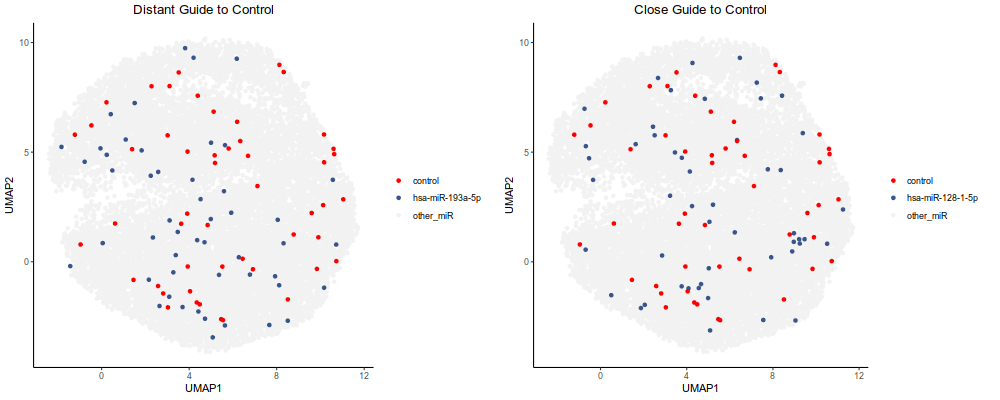

In [99]:
%%R -i nn -h 400 -w 1000

## showing the most distant pertubation to control
library(dplyr)
library(ggpubr)


nn2 = cbind(nn[,1:2], labs = far_guide)
colnames(nn2)[1:2] <- c('UMAP1', 'UMAP2')
a <- ggplot(nn2[order(nn2$labs, decreasing = TRUE),], aes(UMAP1,UMAP2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Distant Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

nn2 = cbind(nn[,1:2], labs = close_guide)
colnames(nn2)[1:2] <- c('UMAP1', 'UMAP2')
b <- ggplot(nn2[order(nn2$labs, decreasing = TRUE),], aes(UMAP1,UMAP2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Close Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

ggarrange(a,b)

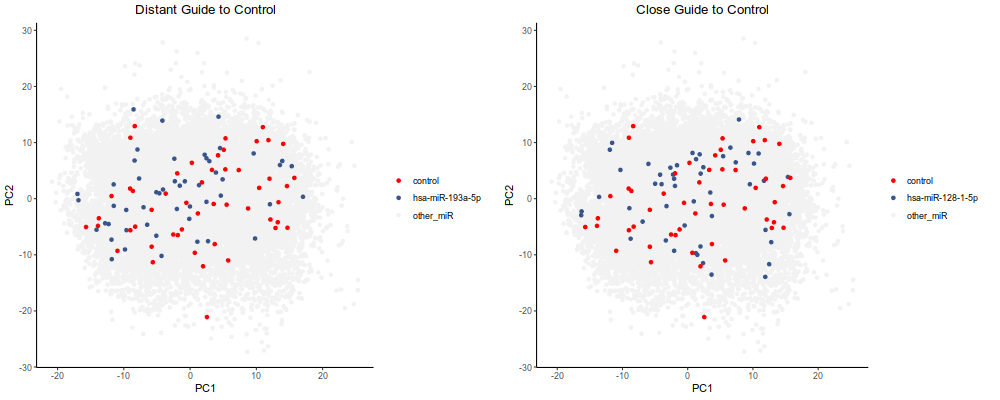

In [100]:
%%R -i nn3 -h 400 -w 1000
## showing the most distant pertubation to control

nn4 = cbind(nn3[,1:2], labs = far_guide)
colnames(nn4)[1:2] <- c('PC1', 'PC2')
a <- ggplot(nn4[order(nn4$labs, decreasing = TRUE),], aes(PC1,PC2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Distant Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

nn4 = cbind(nn3[,1:2], labs = close_guide)
colnames(nn4)[1:2] <- c('PC1', 'PC2')
b <- ggplot(nn4[order(nn4$labs, decreasing = TRUE),], aes(PC1,PC2,color=labs)) + geom_point() +
scale_color_manual(values = c('red', '#39568CFF', 'gray95')) + theme_classic() + ggtitle('Close Guide to Control') + 
theme(legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

ggarrange(a,b)